<a href="https://colab.research.google.com/github/H-haruki-20/MODNet/blob/main/MODNet_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

論文  
https://arxiv.org/abs/2011.11961v3  
  
GitHub  
https://github.com/ZHKKKe/MODNet  
  
<a href="https://colab.research.google.com/github/kaz12tech/ai_demos/blob/master/MODNet_demo.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ランタイムの設定
「ランタイム」→「ランタイムのタイプを変更」→「ハードウェアアクセラレータ」をGPUに変更

# 実行方法
「ランタイム」→「すべてのセルを実行」を選択

# GPU確認

In [ ]:
!nvidia-smi

Sat Jul  1 07:54:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 環境セットアップ

## ライブラリのインポート

In [ ]:
import shutil
from google.colab import files
import os
import numpy as np
from PIL import Image

## GitHubからソースコードを取得

In [ ]:
%cd /content
if not os.path.exists('MODNet'):
  !git clone https://github.com/ZHKKKe/MODNet
%cd MODNet/

/content
Cloning into 'MODNet'...
remote: Enumerating objects: 276, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 276 (delta 0), reused 1 (delta 0), pack-reused 273
Receiving objects: 100% (276/276), 60.77 MiB | 15.75 MiB/s, done.
Resolving deltas: 100% (95/95), done.
/content/MODNet


## 学習済みモデルのダウンロード

In [ ]:
%cd /content/MODNet

pretrained_ckpt = 'pretrained/modnet_photographic_portrait_matting.ckpt'
if not os.path.exists(pretrained_ckpt):
  !gdown --id 1mcr7ALciuAsHCpLnrtG_eop5-EYhbCmz \
          -O pretrained/modnet_photographic_portrait_matting.ckpt

/content/MODNet
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1mcr7ALciuAsHCpLnrtG_eop5-EYhbCmz
To: /content/MODNet/pretrained/modnet_photographic_portrait_matting.ckpt
100% 26.3M/26.3M [00:00<00:00, 140MB/s]


# 予測

## テスト画像のセットアップ
使用画像  
https://www.pakutaso.com/20220130028post-38621.html  
背景画像  
https://pixabay.com/ja/photos/%e3%83%94%e3%82%a2%e3%83%8e-%e3%82%b3%e3%83%b3%e3%82%b5%e3%83%bc%e3%83%88%e3%83%9b%e3%83%bc%e3%83%ab-1508907/  

In [ ]:
input_folder = 'demo/image_matting/colab/input'
if os.path.exists(input_folder):
  shutil.rmtree(input_folder)
os.makedirs(input_folder)

output_folder = 'demo/image_matting/colab/output'
if os.path.exists(output_folder):
  shutil.rmtree(output_folder)
os.makedirs(output_folder)

background_folder = 'demo/image_matting/colab/background'
if os.path.exists(background_folder):
  shutil.rmtree(background_folder)
os.makedirs(background_folder)

In [ ]:
# upload images (PNG or JPG)
image_names = list(files.upload().keys())
for image_name in image_names:
  shutil.move(image_name, os.path.join(input_folder, image_name))

Saving IMG_4817.JPG to IMG_4817.JPG


In [ ]:
replace_image_names = list(files.upload().keys())
for replace_image_name in replace_image_names:
  shutil.move(replace_image_name, os.path.join(input_folder, replace_image_name))

## Inference

In [ ]:
%%time

!python -m demo.image_matting.colab.inference \
    --input-path demo/image_matting/colab/input \
    --output-path demo/image_matting/colab/output \
    --ckpt-path ./pretrained/modnet_photographic_portrait_matting.ckpt


Process image: IMG_4817.JPG
CPU times: user 109 ms, sys: 10 ms, total: 119 ms
Wall time: 17.8 s


## Visualizatoin

In [ ]:
def combined_display(image, matte, replace_image):
  # calculate display resolution
  w, h = image.width, image.height
  rw, rh = 800, int(h * 800 / (3 * w))

  # obtain predicted foreground
  image = np.asarray(image)
  if len(image.shape) == 2:
    image = image[:, :, None]
  if image.shape[2] == 1:
    image = np.repeat(image, 3, axis=2)
  elif image.shape[2] == 4:
    image = image[:, :, 0:3]
  matte = np.repeat(np.asarray(matte)[:, :, None], 3, axis=2) / 255
  # foreground = image * matte + np.full(image.shape, 255) * (1 - matte)
  foreground = image * (1-matte)

  # combine image, foreground, and alpha into one line
  combined = np.concatenate((image, foreground, matte * 255), axis=1)
  combined = Image.fromarray(np.uint8(combined)).resize((rw, rh))
  people = Image.fromarray(np.uint8(foreground)).resize((rh,rw))
  return combined

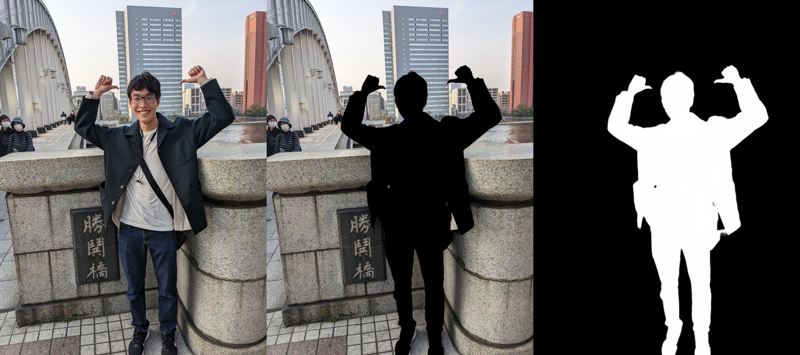

IMG_4817.JPG 



In [ ]:
# visualize all images
image_names = os.listdir(input_folder)
for image_name in image_names:
  matte_name = image_name.split('.')[0] + '.png'
  image = Image.open(os.path.join(input_folder, image_name))
  matte = Image.open(os.path.join(output_folder, matte_name))
  replace_image = Image.open(os.path.join(input_folder,replace_image_name ))
  display(combined_display(image, matte,replace_image))
  print(image_name, '\n')

# 背景合成

In [ ]:
# upload image (PNG or JPG)
backimage_name = list(files.upload().keys())
shutil.move(backimage_name[0], os.path.join(background_folder, backimage_name[0]))

Saving E9A1CB41-B704-4DCE-8A29-B5F41DB0FAF4_4_5005_c.jpeg to E9A1CB41-B704-4DCE-8A29-B5F41DB0FAF4_4_5005_c.jpeg


'demo/image_matting/colab/background/E9A1CB41-B704-4DCE-8A29-B5F41DB0FAF4_4_5005_c.jpeg'

In [ ]:
def background_composition(image_path, matte_path, bg_image_path):
  foreground = Image.open(image_path)
  matte = Image.open(matte_path)
  background = Image.open(bg_image_path).resize(foreground.size)

  composition_img = Image.composite(foreground, background, matte)

  return composition_img

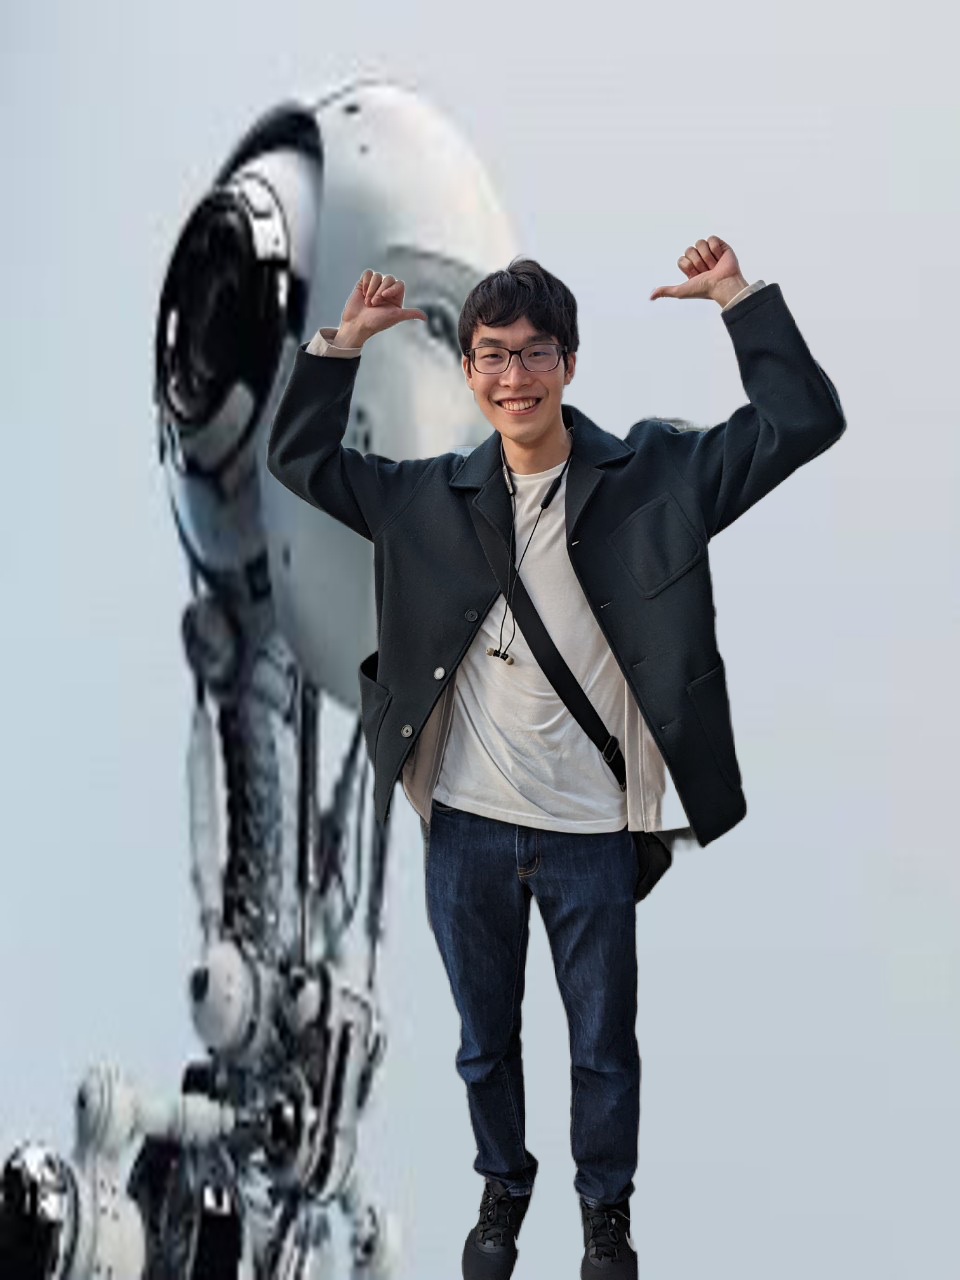

IMG_4817.JPG 



In [ ]:
image_names = os.listdir(input_folder)
for image_name in image_names:
  matte_name = image_name.split('.')[0] + '.png'
  image_path = os.path.join(input_folder, image_name)
  matte_path = os.path.join(output_folder, matte_name)
  bg_image_path = os.path.join(background_folder, backimage_name[0])
  compos_img = background_composition(image_path, matte_path, bg_image_path)
  display(compos_img)
  print(image_name, '\n')

  # 合成画像を保存
  compos_img.save(os.path.join(output_folder, "composition_" + image_name))